### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


#### __problema continuo__

Sea el problema bidimencional pulso gausiano rotatorio definido por la ecuacion: 
$$
\frac{\partial T}{\partial t} - \alpha \nabla  T =Q \  \text{en} \  M=\Omega \times (0,t_f) 
$$

Donde $u(x,t) \in \mathbb{R}$ 
$$\Omega $$
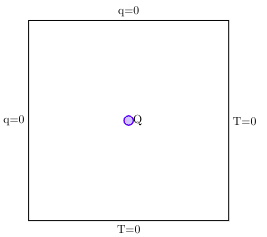

con: 

$$Q=10$$
$$\alpha =0.001$$
## Problema variacional

Encontrar un  $T \ \in \ V$  tal que 
$$
        \int \frac{\partial T}{\partial t}d\Omega +\int \alpha \nabla v \nabla T d\Omega  - \int_{\partial \Omega} \alpha q \cdot n ds - \int Qvd\Omega = 0
$$

In [35]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import time
import scipy
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
from mshr import *
start = time.time()

parameters['linear_algebra_backend'] = 'Eigen'

    
np.set_printoptions(formatter={'float': '{: 0.2E}'.format})
# Parámetros de simulación
T = 100           # Tiempo final
num_steps = 20# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo
k= 1
a=-1
# mesh
elements = 40
start = 0
x_end = 1
alpha=1
beta=1.2
nx = ny =20# Número de divisiones en x e y
mesh = RectangleMesh(Point(-10,-10),Point(10,10),nx,ny) # use for 1D
#mesh = RectangleMesh(Point(start,start), Point(x_end,x_end/8), elements, 12)  # use for 2D

# # boundary markers
# class LeftBoundary(SubDomain):
#     def inside(self, x, on_boundary):
#         return near(x[0], start) and on_boundary


# class RightBoundary(SubDomain):
#     def inside(self, x, on_boundary):
#         return near(x[0], x_end) and on_boundary


# boundaries= MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
# boundaries.set_all(0)

# LeftBoundary().mark(boundaries, 1)  # mark left boundary with a 0
# RightBoundary().mark(boundaries, 2)  # mark right boundary with a 1
V=FunctionSpace(mesh,"CG",1)
# Definición de la condición inicial
u_0 =Expression(('1+pow(x[0],2)+alpha*pow(x[1],2)'),alpha=alpha,degree=1)
u_Analitical=Expression("1 + x[0]*x[0] + alpha *x[1]*x[1] + beta *t",alpha =alpha , beta =beta , t=0 ,degree=1)
u_n=project(u_0,V)

# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)

#bc1 =DirichletBC(V,Constant(20),boundaries,1)
# bc2 =DirichletBC(V,Constant(25),boundaries,2)
# bcs=[bc2]
# ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
K_fem = -dot(grad(u), grad(v))*dx # Formulación débil
Q_fem = -Constant(beta-2-2*alpha)*v*dx

C_fem=u*v*dx
#ensamble vector de cargas

Q_v=assemble(Q_fem)
# [bc.apply(Q_v) for bc in bcs] #penalización
#ensamble matriz capacitiva 
C=assemble(C_fem)
# [bc.apply(C) for bc in bcs]#penalización
#ensamble matriz de rigidez

K=assemble(K_fem)
# [bc.apply(K) for bc in bcs] #penalización


#metodo sparse
K_=scipy.sparse.csr_matrix(K.array()) 


N_degree=C.array().shape[0]
C_=scipy.sparse.csc_matrix(C.array())
I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))
Q_v=Q_v.get_local()

start=time.time()
C_1=scipy.sparse.linalg.spsolve(C_,I_n)

end = time.time()
#metodo coarse np
A=C_1.dot(K_)

A=A.toarray()
A_i=scipy.sparse.linalg.spsolve(A,I_n)
A_i=A_i.toarray()
Q=C_1.dot(Q_v)


# algoritmo de arnoldi 
def fi (A,m,tau=1):
    d=scipy.sparse.identity(m)
    exp_A =scipy.linalg.expm(tau*A)
    return (exp_A-d)*spsl.spsolve(tau*A,d) , exp_A
# algoritmo de arnoldi 
def arnoldi_iteration(A, b,tau):
    m = A.shape[0]
    beta= np.linalg.norm(b)
    tol=1E-16
    n_int=2
    n=n_int
    error=1
    #print("beta on er",beta)
    eta=1/sqrt(2)
    H = np.zeros((n + 1, n))
    V = np.zeros((m, n + 1))
    V[:, 0] = b / beta
    j=0
    while error >= tol:
        if n>2 :
            H=np.pad(H, [(0, 1), (0, 1)], mode='constant', constant_values=0)
            V=np.pad(V, [(0, 0), (0, 1)], mode='constant', constant_values=0)
        e_m=np.zeros(n)
        e_m[n-1]=1
        e_1=np.zeros(n)
        e_1[0]=1
        v = A.dot(V[:, j])
        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i].conj(), v)  # <-- V needs conjugation!
            v = v - H[i, j] * V[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        V[:, j + 1] = v / H[j + 1, j]
        j += 1
        if n>n_int or (n==n_int and j==n_int):
            fi_m,exp_H =fi(H[0:n, 0:n],n,tau)
            error = beta*abs(H[n,n-1]*tau*e_m.dot(np.array(fi_m.dot(e_1))[0]))
            n += 1
    print(f"H dim= {n-1} error = {error}")
    return V[:,0:n-1], H[0:n-1, 0:n-1],fi_m,e_1,n,exp_H 



t= 0
u_=Function(V)


    

print(f"time inv ={end-start}")


u_i=np.dot(A,u_n.vector().get_local())+Q
m=2
v_hat=np.zeros(m)
v_hat[0]=1
#u_i=u_n.vector()
vtkfile_u = XDMFFile("results/u_exp.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False
vtkfile_u_a = XDMFFile("results/u_an.xdmf")
vtkfile_u_a.parameters["flush_output"] = True
vtkfile_u_a.parameters["rewrite_function_mesh"] = False
for n in range(num_steps):
    
    t += dt
    
    
    Beta=np.linalg.norm(u_i)
    V_m,H_m,fi_m,e_1,m,exp_H  = arnoldi_iteration(A,u_i,dt)
    #print(np.linalg.det(H_m))
#     u_.vector()[:]=u_i

    if n==0:
        u = dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)+u_n.vector().get_local()
    else:
        u += dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)
    u_.vector()[:]=np.array(u)[0]
    u_i=np.dot(A,np.array(u)[0])+Q
    u_Analitical.t=t
    u_a = project(u_Analitical,V)
    u_a.rename("u_a", "u_a");vtkfile_u_a.write(u_a, t)
    u_.rename("u_", "u_");vtkfile_u.write(u_, t)
#     Beta=np.linalg.norm(u)
#     print(Beta)
#     if n%100==0:
#         x_cor=np.linspace(0.001,0.999,100)
#         y=[]
#         for i in x_cor:
#             y.append(u_(i))
#         plt.plot(x_cor,y)
#     print(f'step:{n} of {num_steps} time= {t}')

# plt.ylim=[24,25]
# plt.show()

time inv =0.10498833656311035
H dim= 107 error = 0.0
H dim= 69 error = 0.0
H dim= 126 error = 0.0
H dim= 99 error = 0.0
H dim= 75 error = 0.0
H dim= 129 error = 0.0
H dim= 78 error = 0.0
H dim= 171 error = 0.0
H dim= 227 error = 0.0
H dim= 61 error = 0.0
H dim= 141 error = 0.0
H dim= 63 error = 0.0
H dim= 156 error = 0.0
H dim= 84 error = 0.0
H dim= 70 error = 0.0
H dim= 119 error = 0.0
H dim= 55 error = 0.0
H dim= 125 error = 0.0
H dim= 84 error = 0.0
H dim= 46 error = 0.0


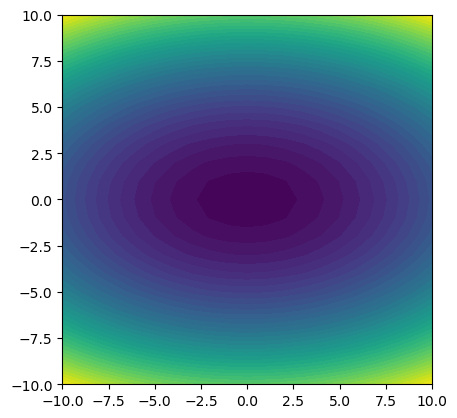

In [27]:
u_Analitical.t=T
u_a = project(u_Analitical,V)
plot(u_a)

In [33]:
Q

array([-2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00,
       -2.80E+00, -2.80E+00, -2.80E+00, -2.80E+00, 

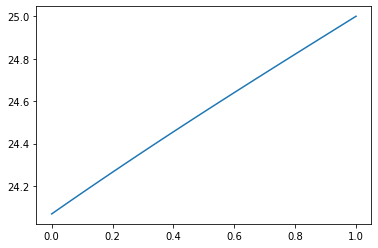

In [10]:
plot(sade)

time: 0.0001


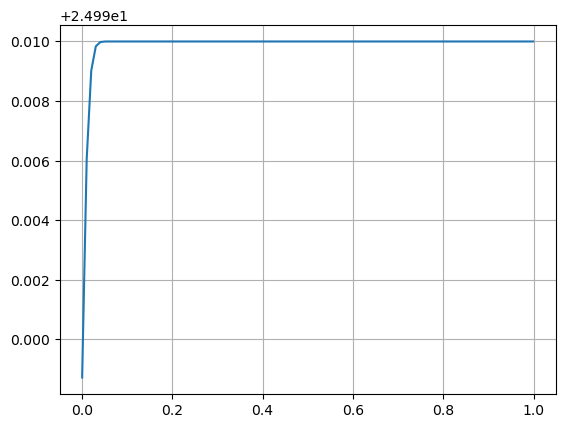

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt 
def b_n(n):
    return 8/((1-2*n)**2*np.pi**2)
def Analytic(x,t):
    print('time:', t)
    s_m=1000
    u=[]
    j=0
    for x_n in x:
        u_j=0
        for n in range(1,s_m):
            u_j += b_n(n)*math.exp(-1*((n-0.5)*np.pi)**2*t)*np.cos((n-0.5)*np.pi*x_n)
        u_j += x_n+24
        u.append(u_j)
    return u
x_a=np.linspace(0,0.999,100)
t_=np.linspace(0.00000000001,2,10)**(2)
t=0.0001
u_a =Analytic(x_a,t )
plt.plot(x_a,u_a)
plt.grid(True)
plt.xlim = [0,1]
plt.ylim = [24,25]

list

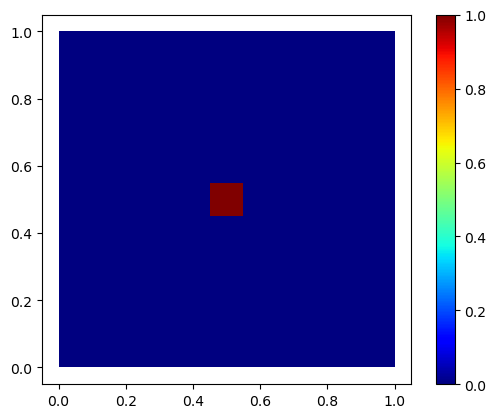

In [2]:
p=plot(subdomain)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

time:  0.16666666666666666
Calling FFC just-in-time (JIT) compiler, this may take some time.
time: Solving linear variational problem.
 0.3333333333333333
time:  0.5
time:  0.6666666666666666
time:  0.8333333333333333
time:  0.9999999999999999
time:  1.1666666666666665
time:  1.3333333333333333
time:  1.5
time:  1.6666666666666667
time:  1.8333333333333335
time:  2.0
time:  2.1666666666666665
time:  2.333333333333333
time:  2.4999999999999996
time:  2.666666666666666
time:  2.8333333333333326
time:  2.999999999999999
time:  3.1666666666666656
time:  3.333333333333332
time:  3.4999999999999987
time:  3.666666666666665
time:  3.8333333333333317
time:  3.9999999999999982
time:  4.166666666666665
time:  4.333333333333332
time:  4.499999999999999
time:  4.666666666666666
time:  4.833333333333333
time:  5.0
time:  5.166666666666667
time:  5.333333333333334
time:  5.500000000000001
time:  5.666666666666668
time:  5.833333333333335
time:  6.000000000000002
time:  6.166666666666669
time:  6.333

Solving linetime:  53.333333333333115
time:  53.49999999999978
time:  53.666666666666444
time:  53.83333333333311
time:  53.99999999999977
time:  54.16666666666644
time:  54.3333333333331
time:  54.499999999999766
time:  54.66666666666643
time:  54.833333333333094
time:  54.99999999999976
time:  55.16666666666642
time:  55.33333333333309
time:  55.49999999999975
time:  55.666666666666416
time:  55.83333333333308
time:  55.999999999999744
time:  56.16666666666641
time:  56.33333333333307
time:  56.49999999999974
time:  56.6666666666664
time:  56.833333333333066
time:  56.99999999999973
time:  57.166666666666394
time:  57.33333333333306
time:  57.49999999999972
time:  57.66666666666639
time:  57.83333333333305
time:  57.999999999999716
time:  58.16666666666638
time:  58.333333333333044
time:  58.49999999999971
time:  58.66666666666637
time:  58.83333333333304
time:  58.9999999999997
time:  59.166666666666366
time:  59.33333333333303
time:  59.499999999999694
time:  59.66666666666636
time

al problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear v

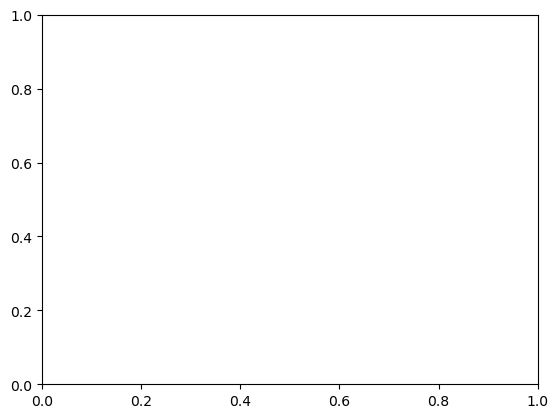

In [38]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import time


from mshr import *
start = time.time()

parameters['linear_algebra_backend'] = 'Eigen'

    
np.set_printoptions(formatter={'float': '{: 0.2E}'.format})
# Parámetros de simulación
T = 100          # Tiempo final
num_steps = 600# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo
k= 1
a=-1
# mesh
alpha=1
beta=1.2
nx = ny =20# Número de divisiones en x e y
mesh = RectangleMesh(Point(-10,-10),Point(10,10),nx,ny) # use for 1D
#mesh = RectangleMesh(Point(start,start), Point(x_end,x_end/8), elements, 12)  # use for 2D


V=FunctionSpace(mesh,"CG",1)
# Definición de la condición inicial
u_0 =Expression(('1+pow(x[0],2)+alpha*pow(x[1],2)'),alpha=alpha,degree=1)
u_Analitical=Expression("1 + x[0]*x[0] + alpha *x[1]*x[1] + beta *t",alpha =alpha , beta =beta , t=0 ,degree=1)




# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)





# Definición del valor inicial
u_n = interpolate(u_0, V)  # Interpola u_D en el espacio de funciones V
u_nn = interpolate(u_0, V) 
u_nnn = interpolate(u_0, V) 


# Formulación del problema variacional
#pconst=[3./2,-2,1./2,0.0] #bdf2
#pconst = [0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3] #bdf2 op
pconst= [11/6,-3,3/2,-1/3] #bdf 3
#pconst=[1,-1,0,0] #bdf1

du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn
t= 0

#bc1 =DirichletBC(V,Constant(20),boundaries,1)
# bc2 =DirichletBC(V,Constant(25),boundaries,2)
# bcs=[bc2]
# ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
F = du_t*v*dx + dt*k*dot(grad(u), grad(v))*dx +(beta-2-2*alpha)*v*dx# Formulación débil

a, L = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación
ig, ax = plt.subplots()
u_=Function(V)
vtkfile_u = XDMFFile("results/u_BDF.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False
for n in range(num_steps):
    

    # Actualizar el tiempo actual
    t += dt
    print("time: ", t)
    # Resolver la solución
#     A=assemble(a)
#     b=assemble(L)
#     [bc.apply(A) for bc in bcs]
#     [bc.apply(b) for bc in bcs]
#     solve(A, u_.vector(),b)
    solve(a==L,u_)
    u_.rename("u_", "u_");vtkfile_u.write(u_, t)
    # Graficar la solución
    #print(f'step:{n} of {num_steps}')
    #print(np.array(u_.vector()).max())
    # Calcular el error
#     u_e = interpolate(u_D, V)  # Interpolar la solución exacta
#     error = np.abs(np.array(u_e.vector()) - np.array(u.vector())).max()  # Error máximo
#     print('t = %.2f: error = %.3g' % (t, error))

    # Actualizar la solución anterior
    u_nnn.assign(u_nn)
    u_nn.assign(u_n)
    u_n.assign(u_)
#     if n%100==0:
#         x_cor=np.linspace(0.001,0.999,100)
#         y=[]
#         for i in x_cor:
#             y.append(u_(i))
#         plt.plot(x_cor,y)
# plt.xlim = [0,1]
# plt.ylim = [24,25]
# plt.show()
        

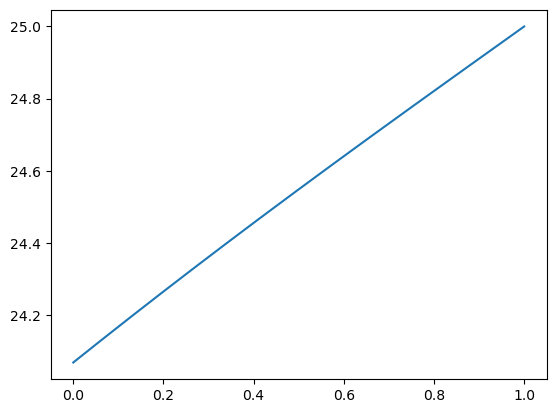

In [8]:
plot(u_)

AttributeError: 'list' object has no attribute 'set_cmap'

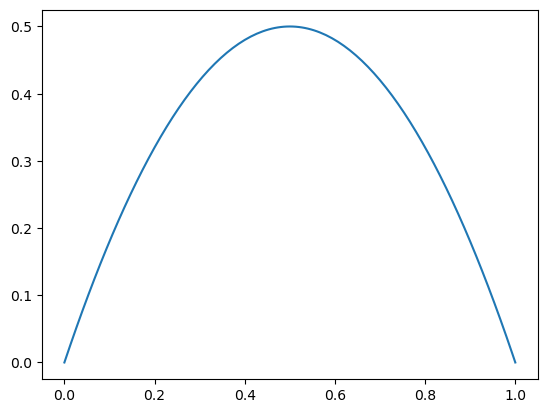

In [56]:
p=plot(u_n)
p.set_cmap ('jet')
plt.colorbar(p)

plt.show()